# Counting and Classification

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import theano
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.special import expit
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sns.set()

## Binomial Regression

### 10.1

In [4]:
d = pd.read_csv("data/chimpanzees.csv", delimiter=";")

### 10.2

In [5]:
shared_prosoc_left = theano.shared(d["prosoc_left"].values)
shared_condition = theano.shared(d["condition"].values)

In [6]:
with pm.Model() as m10_1:
    a = pm.Normal("a", 0, 10)
    p = pm.math.invlogit(a + 0*shared_prosoc_left) # for shared value sampling
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d["pulled_left"])
    trace10_1 = pm.sample(1000, tune=1000)

(pm.summary(trace10_1, alpha=0.11)
 .round(2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1924.29draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.32,0.09,0.0,0.18,0.46,840.3,1.0


### 10.3

In [7]:
expit([0.18, 0.46])

array([0.54487889, 0.61301418])

### 10.4

In [8]:
with pm.Model() as m10_2:
    a = pm.Normal("a", 0, 10)
    bp = pm.Normal("bp", 0, 10)
    p = pm.math.invlogit(a + bp*shared_prosoc_left)
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d["pulled_left"])
    trace10_2 = pm.sample(1000, tune=1000)
    
with pm.Model() as m10_3:
    a = pm.Normal("a", 0, 10)
    bp = pm.Normal("bp", 0, 10)
    bpC = pm.Normal("bpC", 0, 10)
    p = pm.math.invlogit(a + (bp + bpC*shared_condition)*shared_prosoc_left)
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d["pulled_left"])
    trace10_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bp, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1226.53draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 765.06draws/s]


### 10.5

In [9]:
models = pd.DataFrame([[m10_1, trace10_1],
                       [m10_2, trace10_2],
                       [m10_3, trace10_3]],
                      columns=["model", "trace"],
                      index=["m10_1", "m10_2", "m10_3"])

In [10]:
model_comparison = (pm.compare(dict(zip(models["model"], models["trace"])),
                               method='pseudo-BMA')
                    .join(pd.Series(models.index, name="name"))
                    .set_index("name")
                    .sort_values("WAIC"))
model_comparison

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
name,,,,,,,
m10_2,680.63,2.06,0,0.7,9.36,0,0
m10_3,682.47,3.06,1.84,0.28,9.47,0.9,0
m10_1,687.89,0.97,7.26,0.02,7.14,6.23,0


### 10.6

In [11]:
(pm.summary(trace10_3)
 .round(2))

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,0.05,0.13,0.00,-0.17,0.32,1157.55,1.0
bp,0.62,0.22,0.01,0.20,1.07,1191.88,1.0
bpC,-0.12,0.27,0.01,-0.61,0.42,1038.47,1.0


### 10.7

In [12]:
np.exp(0.61)

1.8404313987816374

### 10.8

In [13]:
expit(4)

0.9820137900379085

### 10.9

In [14]:
expit(4 + 0.61)

0.9901462444767687

### 10.10

In [15]:
# dummy data for predictions across treatments
shared_prosoc_left.set_value([0, 1, 0, 1])
shared_condition.set_value([0, 0, 1, 1])

# build prediction ensemble
num_samples = 10000
acc = []
for (_, item) in models.join(model_comparison).iterrows():
    pred = pm.sample_ppc(item["trace"], 
                         samples=int(np.round(item["weight"]*num_samples)),
                         model=item["model"],
                         vars=[item["model"]["pulled_left"]])
    acc.append(pred["pulled_left"])
wp = np.vstack(acc)
wp_groups = np.reshape(wp[:num_samples], (100, 100, 4)).mean(0)

# summarize
wp_mean = wp_groups.mean(0)
wp_pi = pm.hpd(wp_groups, alpha=0.11)

100%|██████████| 2800/2800 [00:10<00:00, 273.79it/s]


### 10.11

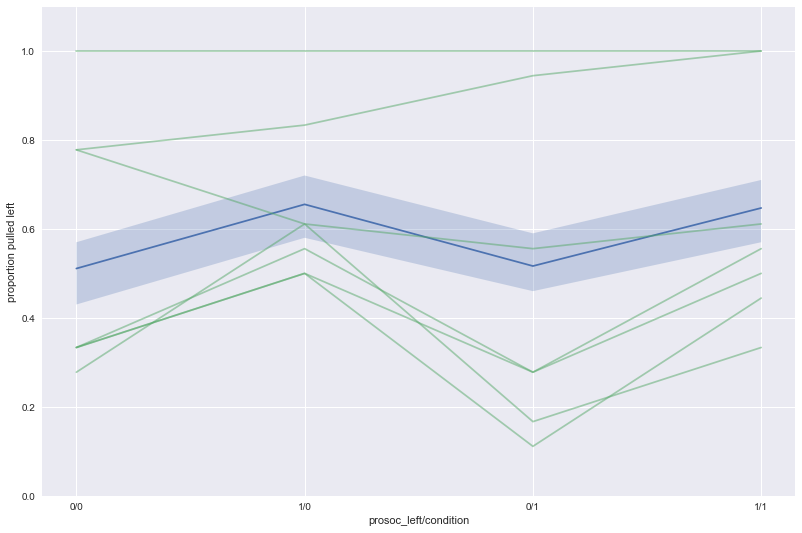

In [16]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

p = (d.groupby(["actor", "prosoc_left", "condition"])
     ["pulled_left"]
     .mean())

ax.plot(range(4), wp_mean)
ax.fill_between(range(4), wp_pi[:,0], wp_pi[:,1], alpha=0.25);

for i in range(1, 8):
    ax.plot(range(4), [p[i, 0, 0], p[i, 1, 0], p[i, 0, 1], p[i, 1, 1]],
            color="C1", alpha=0.5)

ax.set_ylim(0, 1.1)
ax.set_xticks(range(4))
ax.set_xticklabels(["0/0", "1/0", "0/1", "1/1"])
ax.set_xlabel("prosoc_left/condition")
ax.set_ylabel("proportion pulled left");

### 10.12 - 10.13

These don't apply since I'm already using MCMC

### 10.14

In [17]:
shared_actor = theano.shared(d["actor"].values)

In [18]:
shared_condition.set_value(d["condition"].values)
shared_prosoc_left.set_value(d["prosoc_left"].values)

In [19]:
with pm.Model() as m10_4:
    a = pm.Normal("a", 0, 10, shape=len(d["actor"].unique()))
    bp = pm.Normal("bp", 0, 10)
    bpC = pm.Normal("bpC", 0, 10)
    p = pm.math.invlogit(a[shared_actor - 1] + (bp + bpC * shared_condition)*shared_prosoc_left)
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d["pulled_left"])
    trace10_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:10<00:00, 380.78draws/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


### 10.15

In [20]:
d["actor"].unique()

array([1, 2, 3, 4, 5, 6, 7])

### 10.16

In [21]:
(pm.summary(trace10_4, alpha=0.11)
 .round(2))

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a__0,-0.75,0.27,0.01,-1.17,-0.34,1648.56,1.0
a__1,10.83,5.26,0.18,3.61,18.18,748.95,1.0
a__2,-1.05,0.28,0.01,-1.46,-0.57,1484.53,1.0
a__3,-1.05,0.28,0.01,-1.50,-0.61,1278.23,1.0
a__4,-0.75,0.27,0.01,-1.18,-0.31,1384.67,1.0
a__5,0.21,0.27,0.01,-0.22,0.67,1361.26,1.0
a__6,1.80,0.40,0.01,1.18,2.45,1698.11,1.0
bp,0.85,0.26,0.01,0.39,1.24,823.19,1.0
bpC,-0.14,0.31,0.01,-0.61,0.38,1167.03,1.0


### 10.17

In [22]:
post = pm.trace_to_dataframe(trace10_4)
post.head()

,a__0,a__1,a__2,a__3,a__4,a__5,a__6,bp,bpC
0,-0.412696,6.369553,-0.838985,-1.086124,-0.883076,-0.108890,2.111221,0.757670,-0.176692
1,-1.094326,6.917975,-1.219490,-1.189937,-0.734579,0.452353,1.513800,0.769657,0.080717
2,-0.203584,6.931302,-1.185856,-1.543109,-1.056341,0.535587,1.806388,0.561977,0.432204
3,-1.040761,5.985528,-1.101840,-1.210804,-0.980191,0.658517,1.979992,0.946963,-0.066099
4,-0.483928,8.822044,-1.387717,-1.169392,-0.635123,0.783095,2.029615,0.933983,-0.657849


### 10.18

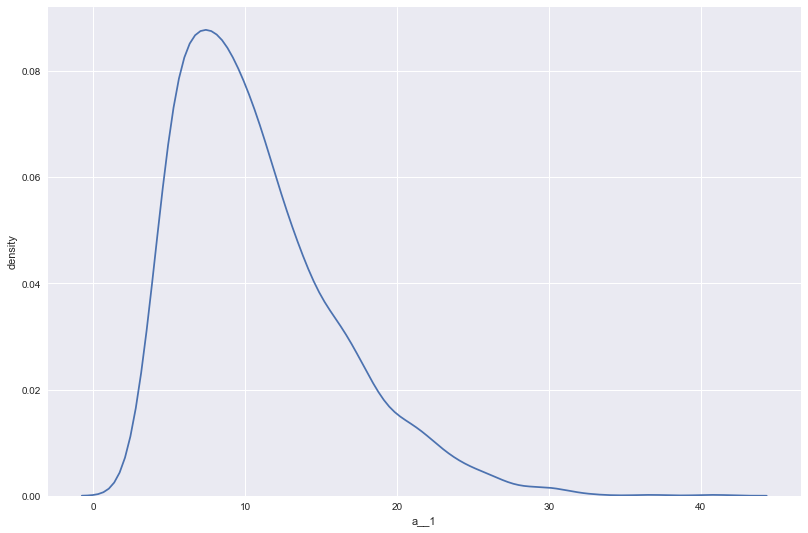

In [23]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
sns.distplot(post["a__1"], hist=False, ax=ax)
ax.set_ylabel("density");

### 10.19

In [24]:
# dummy data for predictions across treatments
num_chimps = len(d["actor"].unique())
prosoc_left_seq = np.tile([0, 1, 0, 1], num_chimps)
condition_seq = np.tile([0, 0, 1, 1], num_chimps)
actor_seq = np.repeat(d["actor"].unique(), 4)

shared_prosoc_left.set_value(prosoc_left_seq)
shared_condition.set_value(condition_seq)
shared_actor.set_value(actor_seq)

In [25]:
predictions = pm.sample_ppc(trace10_4, samples=10000, model=m10_4)["pulled_left"]

100%|██████████| 10000/10000 [00:13<00:00, 738.41it/s]


In [26]:
pred_p_groups = predictions.reshape(100, 100, 28).mean(0)
pred_p = predictions.mean(0)
pred_p_pi = pm.hpd(pred_p_groups, alpha=0.11)
pred_df = (pd.DataFrame({"p": pred_p,
                         "lower": pred_p_pi[:, 0],
                         "upper": pred_p_pi[:, 1],
                         "prosoc_left": prosoc_left_seq,
                         "condition": condition_seq,
                         "actor": actor_seq})
           .set_index(["actor", "prosoc_left", "condition"]))

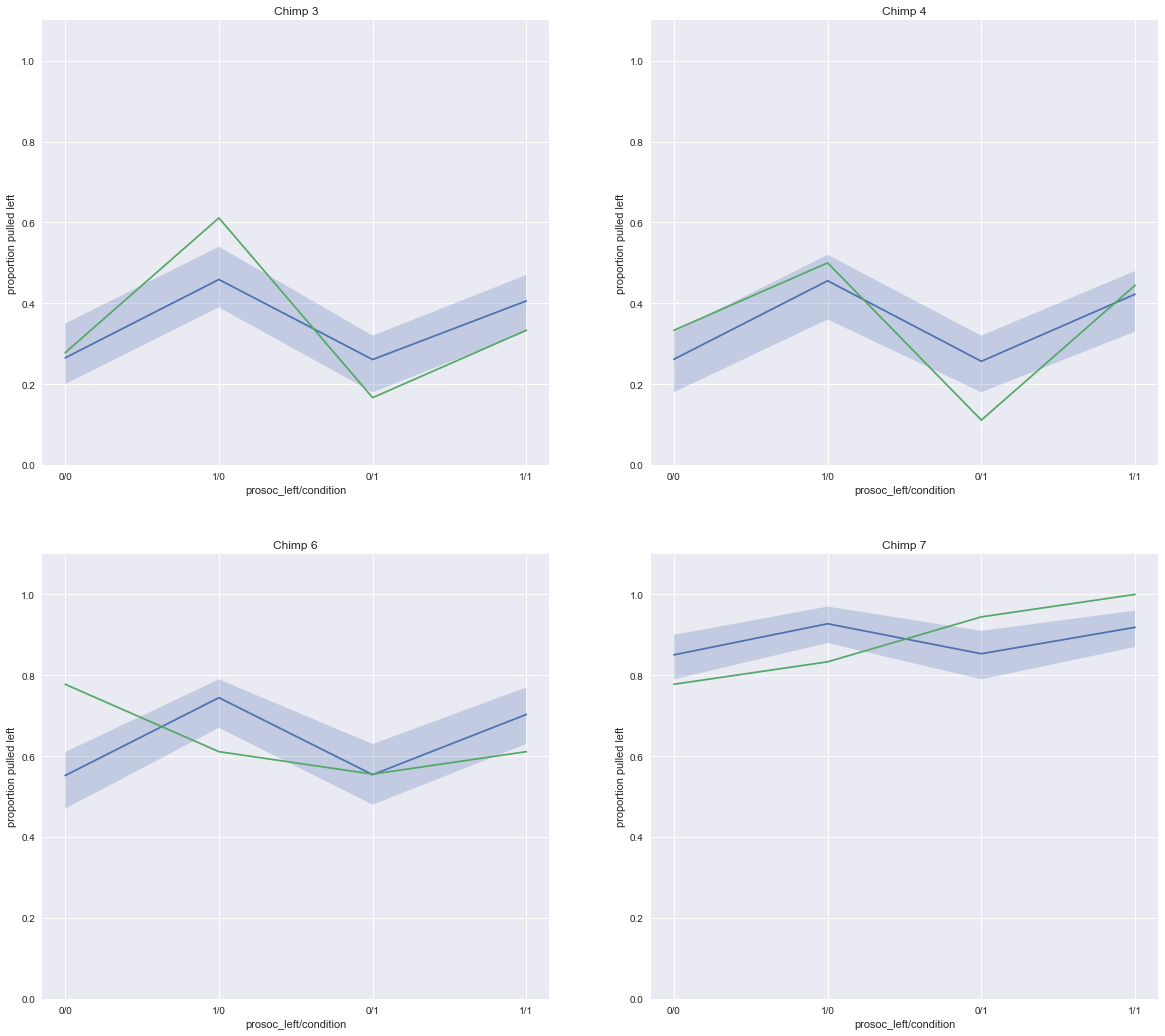

In [27]:
f, axs = plt.subplots(2, 2)
f.set_size_inches(20, 18)

p = (d.groupby(["actor", "prosoc_left", "condition"])
     ["pulled_left"]
     .mean())

for (chimp, (x, y)) in zip([3, 4, 6, 7], [(x, y) for x in range(2) for y in range(2)]):
    ax = axs[x][y]
    ax.plot(range(4), pred_df.loc[chimp]["p"])
    ax.fill_between(range(4), 
                    pred_df.loc[chimp]["lower"], 
                    pred_df.loc[chimp]["upper"], 
                    alpha=0.25)
    ax.plot()
    ax.plot(range(4), [p[chimp, 0, 0], p[chimp, 1, 0], p[chimp, 0, 1], p[chimp, 1, 1]], 
            color="C1")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(range(4))
    ax.set_xticklabels(["0/0", "1/0", "0/1", "1/1"])
    ax.set_xlabel("prosoc_left/condition")
    ax.set_ylabel("proportion pulled left")
    ax.set_title("Chimp {}".format(chimp));

### 10.20

In [28]:
d = pd.read_csv("data/chimpanzees.csv", delimiter=";")
d_aggregated = (d.groupby(["actor", "prosoc_left", "condition"])
                [["pulled_left"]]
                .sum()
                .reset_index())
d_aggregated.head(8)

,actor,prosoc_left,condition,pulled_left
0,1,0,0,6
1,1,0,1,5
2,1,1,0,9
3,1,1,1,10
4,2,0,0,18
5,2,0,1,18
6,2,1,0,18
7,2,1,1,18


### 10.21

In [29]:
with pm.Model() as m10_5:
    a = pm.Normal("a", 0, 10)
    bp = pm.Normal("bp", 0, 10)
    bpC = pm.Normal("bpC", 0, 10)
    p = pm.math.invlogit(a + (bp + bpC*d_aggregated["condition"])*d_aggregated["prosoc_left"])
    pulled_left = pm.Binomial("pulled_left", 18, p, observed=d_aggregated["pulled_left"])
    trace10_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bpC, bp, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 795.64draws/s] 


### 10.22

In [30]:
d = pd.read_csv("data/UCBadmit.csv", delimiter=";")

### 10.23

In [31]:
d["male"] = np.where(d["applicant.gender"] == "male", 1, 0)

with pm.Model() as m10_6:
    a = pm.Normal("a", 0, 10)
    bm = pm.Normal("bm", 0, 10)
    p = pm.math.invlogit(a + bm*d["male"])
    admit = pm.Binomial("admit", d["applications"], p, observed=d["admit"])
    trace10_6 = pm.sample(1000, tune=1000)

with pm.Model() as m10_7:
    a = pm.Normal("a", 0, 10)
    p = pm.math.invlogit(a)
    admit = pm.Binomial("admit", d["applications"], p, observed=d["admit"])
    trace10_7 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bm, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 812.30draws/s] 
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2059.25draws/s]


### 10.24

In [32]:
models = pd.DataFrame([[m10_6, trace10_6],
                       [m10_7, trace10_7]],
                      columns=["model", "trace"],
                      index=["m10_6", "m10_7"])

In [33]:
model_comparison = (pm.compare(dict(zip(models["model"], models["trace"])),
                               method='pseudo-BMA')
                    .join(pd.Series(models.index, name="name"))
                    .set_index("name")
                    .sort_values("WAIC"))
model_comparison

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
name,,,,,,,
m10_6,1003.96,115.93,0,1,317.19,0,1
m10_7,1043.81,81.06,39.85,0,312.77,156.18,1


### 10.25

In [34]:
(pm.summary(trace10_6, alpha=0.11)
 .round(2))

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-0.83,0.05,0.0,-0.9,-0.74,463.79,1.01
bm,0.61,0.06,0.0,0.5,0.71,512.64,1.01


### 10.26

In [35]:
post = pm.trace_to_dataframe(trace10_6)
p_admit_male = expit(post["a"] + post["bm"])
p_admit_female = expit(post["a"])
diff_admit = p_admit_male - p_admit_female
np.percentile(diff_admit, [25, 50, 97.5])

array([0.13166185, 0.14209317, 0.16962639])

### 10.27

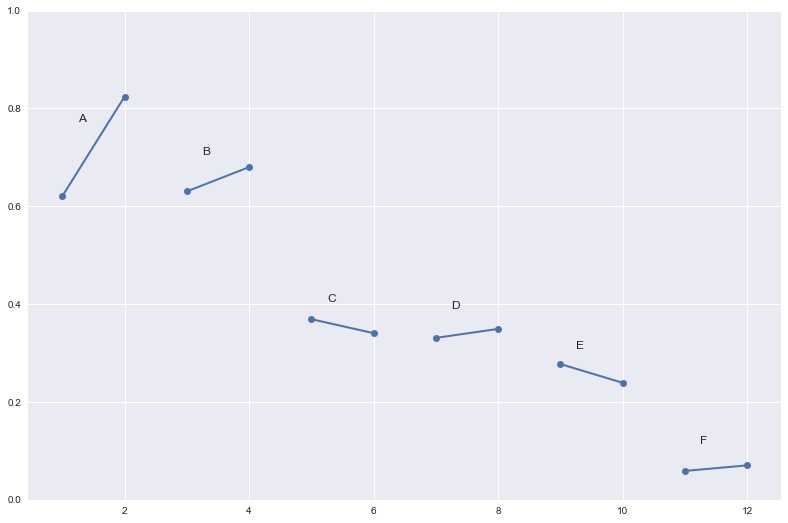

In [36]:
# Ignoring the Postcheck function

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

for i in range(6):
    x = 1 + 2 * i
    y1 = d["admit"][x]/d["applications"][x]
    y2 = d["admit"][x+1]/d["applications"][x+1]
    ax.plot([x, x+1], [y1, y2], '-C0o', lw=2)
    ax.text(x + 0.25, (y1+y2)/2 + 0.05, d["dept"][x])
ax.set_ylim(0, 1);

### 10.28

In [37]:
d["dept_id"] = pd.Categorical(d["dept"]).codes

In [38]:
# Model with unique intercept for each department
with pm.Model() as m10_8:
    a = pm.Normal("a", 0, 10, shape=len(d["dept_id"].unique()))
    p = pm.math.invlogit(a[d["dept_id"].values])
    admit = pm.Binomial("admit", d["applications"], p, observed=d["admit"])
    trace10_8 = pm.sample(1000, tune=1000)

# Model with male difference as well
with pm.Model() as m10_9:
    a = pm.Normal("a", 0, 10, shape=len(d["dept_id"].unique()))
    bm = pm.Normal("bm", 0, 10)
    p = pm.math.invlogit(a[d["dept_id"].values] + bm*d["male"])
    admit = pm.Binomial("admit", d["applications"], p, observed=d["admit"])
    trace10_9 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1505.94draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bm, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 902.46draws/s] 


### 10.29

In [39]:
models = pd.DataFrame([[m10_6, trace10_6],
                       [m10_7, trace10_7],
                       [m10_8, trace10_8],
                       [m10_9, trace10_9]],
                      columns=["model", "trace"],
                      index=["m10_6", "m10_7", "m10_8", "m10_9"])

In [40]:
model_comparison = (pm.compare(dict(zip(models["model"], models["trace"])),
                               method='pseudo-BMA')
                    .join(pd.Series(models.index, name="name"))
                    .set_index("name")
                    .sort_values("WAIC"))
model_comparison

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
name,,,,,,,
m10_8,105.14,6.5,0,0.81,17.17,0,1
m10_9,108.03,9.2,2.89,0.19,15.55,3.53,1
m10_6,1003.96,115.93,898.82,0,317.19,314.26,1
m10_7,1043.81,81.06,938.67,0,312.77,310.51,1


These numbers, and the numbers for WAIC in general look different from the book, this is possibly why 

> The WAIC function in rethinking detects aggregated binomial models and automatically splits them apart into 0/1 Bernoulli trials, for the pur- pose of calculating WAIC.

Check the __overthinking:WAIC and aggregated binomial models__ box for more detail, 

### 10.30

In [41]:
(pm.summary(trace10_9)
 .round(2))

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a__0,0.68,0.10,0.0,0.48,0.87,1262.73,1.0
a__1,0.64,0.11,0.0,0.39,0.85,1183.14,1.0
a__2,-0.58,0.07,0.0,-0.73,-0.44,2289.83,1.0
a__3,-0.61,0.09,0.0,-0.78,-0.46,1686.37,1.0
a__4,-1.06,0.10,0.0,-1.23,-0.86,2397.43,1.0
a__5,-2.63,0.16,0.0,-2.94,-2.35,2032.40,1.0
bm,-0.10,0.08,0.0,-0.27,0.05,1090.98,1.0


### 10.31

All these models are fit with MCMC

### 10.32

In [42]:
import statsmodels.api as sm
from patsy import dmatrix

endog = d.loc[:, ["admit", "reject"]].values

m10_7glm = sm.GLM(endog, dmatrix('~ 1', data=d), family=sm.families.Binomial())
m10_6glm = sm.GLM(endog, dmatrix('~ male', data=d), family=sm.families.Binomial())
m10_8glm = sm.GLM(endog, dmatrix('~ dept_id', data=d), family=sm.families.Binomial())
m10_9glm = sm.GLM(endog, dmatrix('~ male + dept_id', data=d), family=sm.families.Binomial())

### 10.33

In [43]:
import statsmodels.formula.api as smf
chimpanzees = pd.read_csv("data/chimpanzees.csv", delimiter=";")
m10_4glm = smf.glm("pulled_left ~ C(actor) + prosoc_left*condition - condition", data=chimpanzees, 
                   family=sm.families.Binomial())

### 10.34

In [44]:
pm.GLM.from_formula("pulled_left ~ prosoc_left*condition - condition", data=chimpanzees,
                    family="binomial")

### 10.35

In [45]:
y = np.hstack([np.zeros(10), np.ones(10)])
x = np.hstack([np.zeros(9)-1, np.ones(11)])
m_bad = smf.glm("y ~ x", 
                data=pd.DataFrame({"x": x, "y": y}), 
                family=sm.families.Binomial()).fit()
m_bad.summary(alpha=0.11)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3.3510
Date:                Tue, 07 May 2019   Deviance:                       6.7020
Time:                        12:34:19   Pearson chi2:                     11.0
No. Iterations:                    21   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.055      0.945]
------------------------------------------------------------------------------
Intercept    -10.1317   8032.690     -0.001      0.999   -1.28e+04    1.28e+04
x             12.4343   8032.690      0.002      0.999   -1.28e+04    1.29e+04
==============================================================================
"""

### 10.36

In [46]:
with pm.Model() as m_good:
    ab = pm.Normal("ab", 0, 10, shape=2)
    p = pm.math.invlogit(ab[0] + ab[1]*x)
    y_out = pm.Binomial("y_out", 1, p, observed=y)
    MAP = pm.find_MAP()

MAP

logp = -9.9185, ||grad|| = 7.2889e-05: 100%|██████████| 13/13 [00:00<00:00, 1101.71it/s]  


{'ab': array([-1.72704484,  4.01710522])}

### 10.37

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ab]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 959.43draws/s] 
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


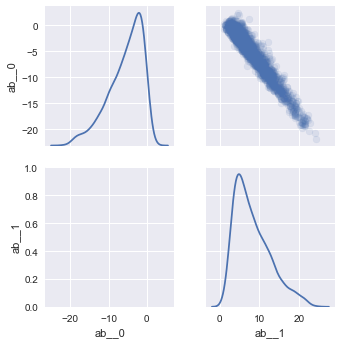

In [47]:
tracem_good = pm.sample(1000, tune=1000, model=m_good)
m_good_df = pm.trace_to_dataframe(tracem_good)
(sns.PairGrid(m_good_df, diag_sharey=False)
 .map_diag(sns.kdeplot)
 .map_upper(plt.scatter, alpha=0.11));

### 10.38

In [48]:
y = stats.binom.rvs(1000, 1/1000, size=int(1e5))
(y.mean(), y.var())

(0.99673, 1.0002593071)

### 10.39

In [49]:
d = pd.read_csv("data/Kline.csv", delimiter=";")
d.head()

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0


### 10.40

In [50]:
d["log_pop"] = np.log(d["population"])
d["contact_high"] = np.where(d["contact"] == "high", 1, 0)

### 10.41

In [51]:
shared_log_pop = theano.shared(d["log_pop"].values)
shared_contact_high = theano.shared(d["contact_high"].values)

In [52]:
with pm.Model() as m10_10:
    b = pm.Normal("b", 0, 1, shape=3)
    a = pm.Normal("a", 0, 100)
    lam = pm.math.exp(a +\
                      b[0]*shared_log_pop +\
                      b[1]*shared_contact_high +\
                      b[2]*shared_log_pop*shared_contact_high)
    total_tools = pm.Poisson("total_tools", lam, observed=d["total_tools"])
    trace10_10 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:20<00:00, 190.94draws/s]


### 10.42

      mean    sd  mc_error  hpd_5.5  hpd_94.5   n_eff  Rhat
b__0  0.26  0.04      0.00     0.20      0.32  543.76  1.01
b__1 -0.11  0.83      0.03    -1.46      1.15  746.39  1.01
b__2  0.04  0.09      0.00    -0.10      0.19  748.55  1.01
a     0.94  0.38      0.02     0.41      1.61  531.74  1.01


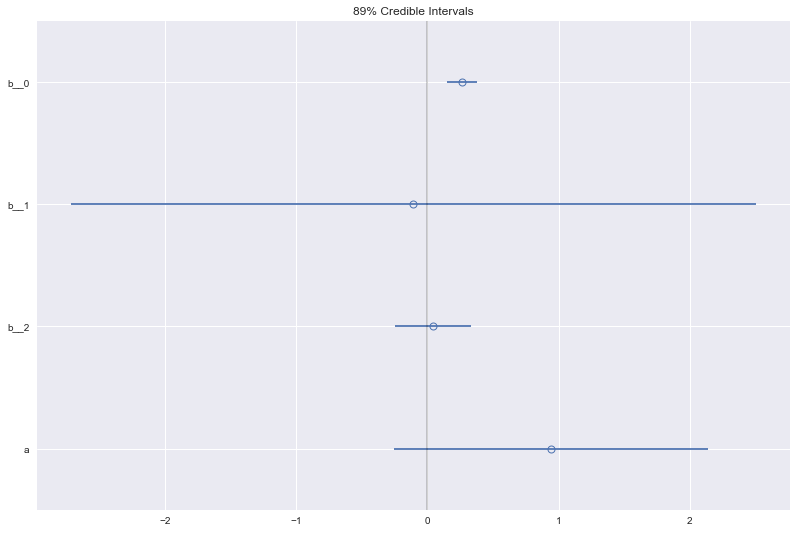

In [53]:
print(pm.summary(trace10_10, alpha=0.11)
      .round(2))

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
data = pm.summary(trace10_10, alpha=0.11)
ax.errorbar(data["mean"], data.index, fmt="o", xerr=data["hpd_94.5"] - data["hpd_5.5"], 
            mew=1, mfc="None")
ax.vlines(0, ymin=-1, ymax=4, alpha=0.2);
ax.set_ylim(-0.5, 3.5)
ax.invert_yaxis()
ax.set_title("89% Credible Intervals");

### 10.43

In [54]:
lambda_high = np.exp(trace10_10["a"] + trace10_10["b"][:, 1] + (trace10_10["b"][:, 0] + trace10_10["b"][:, 2])*8)
lambda_low = np.exp(trace10_10["a"] + trace10_10["b"][:, 0]*8)

### 10.44

In [55]:
diff = lambda_high - lambda_low
sum(diff > 0)/len(diff)

0.954

### 10.45

In [56]:
# No Interaction
with pm.Model() as m10_11:
    b = pm.Normal("b", 0, 1, shape=3)
    a = pm.Normal("a", 0, 100)
    lam = pm.math.exp(a +\
                      b[0]*shared_log_pop +\
                      b[1]*shared_contact_high)
    total_tools = pm.Poisson("total_tools", lam, observed=d["total_tools"])
    trace10_11 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:10<00:00, 387.35draws/s]
The acceptance probability does not match the target. It is 0.8788209471022057, but should be close to 0.8. Try to increase the number of tuning steps.


### 10.46

In [57]:
# No Contact Rate
with pm.Model() as m10_12:
    b = pm.Normal("b", 0, 1, shape=3)
    a = pm.Normal("a", 0, 100)
    lam = pm.math.exp(a +\
                      b[0]*shared_log_pop)
    total_tools = pm.Poisson("total_tools", lam, observed=d["total_tools"])
    trace10_12 = pm.sample(1000, tune=1000)
    
# No Log Population
with pm.Model() as m10_13:
    b = pm.Normal("b", 0, 1, shape=3)
    a = pm.Normal("a", 0, 100)
    lam = pm.math.exp(a +\
                      b[1]*shared_contact_high)
    total_tools = pm.Poisson("total_tools", lam, observed=d["total_tools"])
    trace10_13 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:11<00:00, 362.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 773.03draws/s] 


### 10.47

In [58]:
# Intercept Only
with pm.Model() as m10_14:
    a = pm.Normal("a", 0, 100)
    lam = pm.math.exp(a)
    total_tools = pm.Poisson("lam", lam, observed=d["total_tools"])
    trace10_14 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1875.56draws/s]


In [59]:
models = pd.DataFrame([[m10_10, trace10_10],
                       [m10_11, trace10_11],
                       [m10_12, trace10_12],
                       [m10_13, trace10_13],
                       [m10_14, trace10_14]],
                      columns=["model", "trace"],
                      index=pd.Series(["m10_10", "m10_11", "m10_12", "m10_13", "m10_14"], name="name"))

In [60]:
islands_compare = (pm.compare(dict(zip(models["model"], models["trace"])),
                              method='pseudo-BMA')
                   .join(pd.Series(models.index))
                   .set_index("name")
                   .sort_values("WAIC"))
islands_compare

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
name,,,,,,,
m10_11,79.05,4.18,0,0.6,10.98,0,1
m10_10,80.02,4.78,0.98,0.37,11.18,1.12,1
m10_12,84.51,3.76,5.46,0.04,8.92,7.91,1
m10_14,142.33,8.82,63.29,0,31.96,32.94,1
m10_13,150.95,16.88,71.9,0,45.19,44.83,1


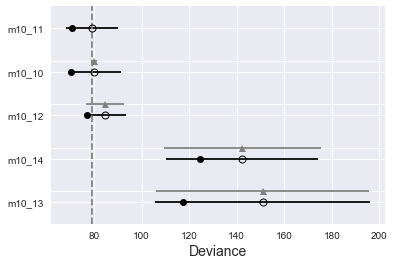

In [61]:
pm.compareplot(islands_compare);

### 10.48

In [62]:
log_pop_seq = np.linspace(6, 13, 30) 
shared_log_pop.set_value(np.hstack([log_pop_seq, log_pop_seq]))
shared_contact_high.set_value(np.hstack([np.zeros(30, int), np.ones(30, int)]))

ensemble = (models.loc[["m10_10", "m10_11", "m10_12"]]
            .join(islands_compare))

wp = pm.sample_ppc_w(ensemble["trace"],
                     samples=10000,
                     models=ensemble["model"],
                     weights=ensemble["weight"])["total_tools"]

# summarize
wp_mean = wp.mean(0)
wp_pi = pm.hpd(wp, alpha=0.11)

100%|██████████| 10000/10000 [00:09<00:00, 1015.60it/s]


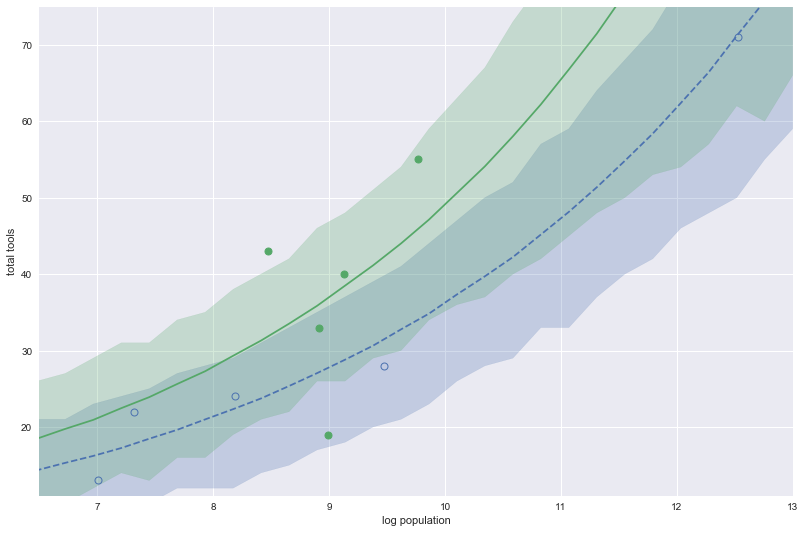

In [63]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

idx = d["contact_high"] == 0
ax.plot(d["log_pop"][idx], d["total_tools"][idx], "o", mew=1.0, mec="C0", mfc="None")
ax.plot(d["log_pop"][~idx], d["total_tools"][~idx], "o", mew=1.0, mec="C1", mfc="C1")

ax.plot(log_pop_seq, wp_mean[:30], "--", color="C0")
ax.fill_between(log_pop_seq, wp_pi[:30,0], wp_pi[:30,1], alpha=0.25, color="C0")
ax.plot(log_pop_seq, wp_mean[30:], color="C1")
ax.fill_between(log_pop_seq, wp_pi[30:,0], wp_pi[30:,1], alpha=0.25, color="C1")
ax.set_xlabel("log population")
ax.set_ylabel("total tools")
ax.set_xlim(6.5, 13)
ax.set_ylim(11, 75);

### 10.49

Already using MCMC

In [64]:
d["log_pop_c"] = d["log_pop"] - d["log_pop"].mean()

with pm.Model() as m10_10c:
    a = pm.Normal("a", 0, 10)
    bp = pm.Normal("bp", 0, 1)
    bc = pm.Normal("bc", 0, 1)
    bcp = pm.Normal("bcp", 0, 1)
    lam = pm.math.exp(a +\
                      bp*d["log_pop_c"] +\
                      bc*d["contact_high"] +\
                      bcp*d["log_pop_c"]*d["contact_high"])
    total_tools = pm.Poisson("total_tools", lam, observed=d["total_tools"])
    trace10_10c = pm.sample(1000, tune=1000)

(pm.summary(trace10_10c, alpha=0.11)
 .round(2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bcp, bc, bp, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 777.98draws/s] 


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,3.31,0.09,0.0,3.17,3.45,1089.52,1.0
bp,0.26,0.03,0.0,0.21,0.32,1167.50,1.0
bc,0.28,0.11,0.0,0.09,0.45,1346.62,1.0
bcp,0.07,0.17,0.0,-0.21,0.32,1622.52,1.0


### 10.51

In [65]:
num_days = 30
y = stats.poisson.rvs(1.5, size=num_days)

### 10.52

In [66]:
num_weeks = 4
y_new = stats.poisson.rvs(0.5*7, size=num_weeks)

### 10.53

In [67]:
y_all = np.hstack([y, y_new])
exposure = np.hstack([np.ones(30, int), np.repeat(7, 4)])
monastery = np.hstack([np.zeros(30, int), np.ones(4, int)])
d = pd.DataFrame({"y": y_all,
                  "days": exposure,
                  "monastery": monastery})

### 10.54

In [68]:
# compute the offset
d["log_days"] = np.log(d["days"])

# fit the model
with pm.Model() as m10_15:
    a = pm.Normal("a", 0, 100)
    b = pm.Normal("b", 0, 1)
    lam = pm.math.exp(a +\
                      d["log_days"] +\
                      b*d["monastery"])
    y = pm.Poisson("y", lam, observed=d["y"])
    trace10_15 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1612.93draws/s]


### 10.55

In [69]:
trace10_15.add_values(dict(lambda_old=np.exp(trace10_15['a']),
                           lambda_new=np.exp(trace10_15['a'] + trace10_15['b'])))

(pm.summary(trace10_15, varnames=['lambda_old', 'lambda_new'], alpha=.11)
 .round(2))

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
lambda_old,1.36,0.22,0.01,1.03,1.70,1241.74,1.0
lambda_new,0.47,0.13,0.00,0.26,0.64,1366.76,1.0


## Other Count Regressions

### 10.56

In [70]:
N = 500
income = np.arange(1, 4)
score = 0.5*income
p = np.exp(score)/np.exp(score).sum()
career = np.where(stats.multinomial.rvs(1, p, size=N) == 1)[1]

### 10.57

In [71]:
import theano.tensor as tt

with pm.Model() as m10_16:
    b = pm.Normal("b", 0, 5)
    s3 = b*3
    s2 = b*2
    p = tt.stack([0, s2, s3])
    career_ = pm.Categorical("career", p=tt.nnet.softmax(p), observed=career)
    trace10_16 = pm.sample(1000, tune=1000)

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1465.39draws/s]


### 10.58

In [72]:
N = 100
family_income = stats.uniform.rvs(size=N)
b = np.arange(-1, 2)
score = (0.5*np.arange(1, 4) + np.outer(family_income, b))
p = (np.exp(score).T/np.exp(score).sum(1)).T
career = np.where(np.asarray([stats.multinomial.rvs(1, pp) for pp in p]) == 1)[1]

In [73]:
with pm.Model() as m10_17:
    a2 = pm.Normal("a2", 0, 5)
    b2 = pm.Normal("b2", 0, 5)
    a3 = pm.Normal("a3", 0, 5)
    b3 = pm.Normal("b3", 0, 5)
    s2 = a2 + b2*family_income
    s3 = a3 + b3*family_income
    p = tt.stack([np.zeros(N), s2, s3]).T
    career_ = pm.Categorical("career", p=tt.nnet.softmax(p), observed=career)
    trace10_17 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b3, a3, b2, a2]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:21<00:00, 183.04draws/s]
The acceptance probability does not match the target. It is 0.8791514580359346, but should be close to 0.8. Try to increase the number of tuning steps.


### 10.59

In [74]:
d = pd.read_csv("data/UCBadmit.csv", delimiter=";")

### 10.60

In [75]:
with pm.Model() as m_binom:
    a = pm.Normal("a", 0, 100)
    p = pm.math.invlogit(a)
    admit = pm.Binomial("admit", p=p, n=d["applications"], observed=d["admit"])
    trace_binom = pm.sample(1000, tune=1000)
    
with pm.Model() as m_pois:
    a = pm.Normal("a", 0, 100, shape=2)
    lam = pm.math.exp(a)
    admit = pm.Poisson("admit", lam[0], observed=d["admit"])
    rej = pm.Poisson("rej", lam[1], observed=d["reject"])
    trace_pois = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 719.26draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 649.45draws/s]


###  10.61

In [76]:
expit(pm.summary(trace_binom)["mean"])

a    0.387687
Name: mean, dtype: float64

### 10.62

In [77]:
k = pm.summary(trace_pois)["mean"]
np.exp(k["a__0"])/(np.exp(k["a__0"])+np.exp(k["a__1"]))

0.38789710916510356

### 10.63

In [78]:
N = 100
x = stats.uniform.rvs(size=N)
y = stats.geom.rvs(expit(-1 + 2*x))

with pm.Model() as m10_18:
    a = pm.Normal("a", 0, 10)
    b = pm.Normal("b", 0, 1)
    p = pm.math.invlogit(a + b*x)
    obs = pm.Geometric("y", p=p, observed=y)
    trace10_18 = pm.sample(1000, tune=1000)

(pm.summary(trace10_18, alpha=0.11)
 .round(2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 962.25draws/s] 
The acceptance probability does not match the target. It is 0.8787185652190592, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-0.95,0.22,0.01,-1.29,-0.60,386.16,1.01
b,2.15,0.43,0.02,1.45,2.84,436.45,1.01
